<a href="https://colab.research.google.com/github/maria-yampolskaya/ProjectOAK/blob/main/ProjectOAK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg #for image reading
import csv                       #for csv reading

try:
    import QOL.plots as pqol
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

In [2]:
#enter file locations here!
CSVFILENAME  = 'dataset/pokemon.csv'
IMAGESFOLDER = 'dataset/images/images/'

In [3]:
## get data from csv file
with open(CSVFILENAME) as csvfileobj:
    csvreader = csv.reader(csvfileobj)
    csvdata = [row for row in csvreader]

In [4]:
## pad single-typed pokemon with a second type ('None')
pad = 'None'
paddata = np.array([row if len(row)==3 else row+[pad] for row in csvdata])

In [5]:
## definitions for convenience (i.e. possibly useful definitions)
alltypes = np.sort(np.unique(paddata[1:, 1:3]))  #will include pad as a type though..
IDXTYPE = {alltypes[i]:str(i) for i in range(len(alltypes))}
TYPEIDX = {str(i):alltypes[i] for i in range(len(alltypes))}
idxdata = np.array([[row[0], IDXTYPE[row[1]], IDXTYPE[row[2]]] for row in paddata[1:]])

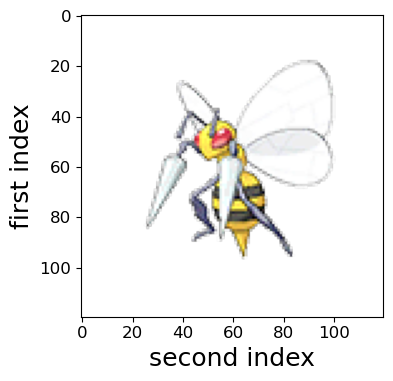

In [6]:
## load image
def get_image(pokename, folder=IMAGESFOLDER, ext='.png'):
    """returns image of pokemon named <pokename>."""
    return mpimg.imread(os.path.join(folder, pokename+ext))

#example:
imgdata = get_image('beedrill')
plt.imshow(imgdata)
plt.ylabel('first index')
plt.xlabel('second index')
plt.show()

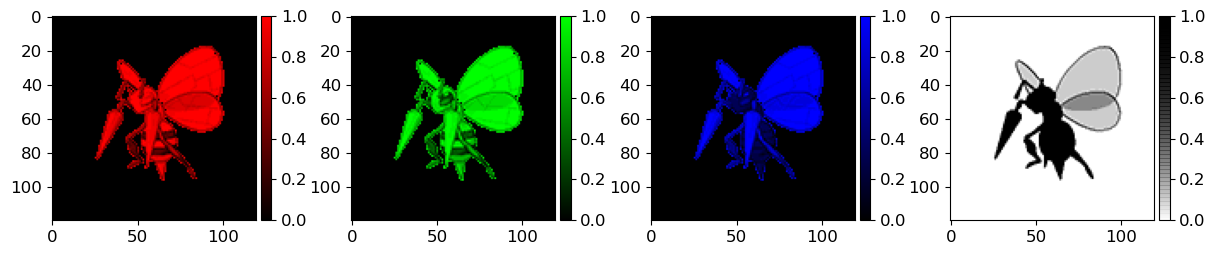

In [7]:
## images in true color channels (rgba), because we can
from matplotlib import colors
z = np.zeros(256)
l = np.linspace(0.0,1.0,256)
Rcmap = colors.ListedColormap(np.array([l, z, z, z+1]).T)
Gcmap = colors.ListedColormap(np.array([z, l, z, z+1]).T)
Bcmap = colors.ListedColormap(np.array([z, z, l, z+1]).T)
Acmap = colors.ListedColormap(np.array([z, z, z, l  ]).T)
fig, axs = plt.subplots(1,4, figsize=(12,3))
plt.sca(axs[0]); plt.imshow(imgdata[:,:,0], cmap=Rcmap); pqol.colorbar()
plt.sca(axs[1]); plt.imshow(imgdata[:,:,1], cmap=Gcmap); pqol.colorbar()
plt.sca(axs[2]); plt.imshow(imgdata[:,:,2], cmap=Bcmap); pqol.colorbar()
plt.sca(axs[3]); plt.imshow(imgdata[:,:,3], cmap=Acmap); pqol.colorbar()
plt.tight_layout(pad=0.1)

## Single-type classification (the simplest problem)

In [8]:
## let's first make a single-label neural network which only assigns one type per pokemon.
# This is most similar to what we've done already.
# I think it should just ignore the info about secondary types.


## Multi-label classification (a non-trivial generalization?)

In [9]:
## We want to have images be assigned two labels (the second label possibly being 'None').
# apparently this problem (of assigning multiple labels) is known more generally as 'Multi-label classification'.
# it might be nontrivial.

## Some thoughts:
# - I think it will be cool to see if including two labels actually leads to improvements on accuracy...
# - I feel like usually type1 and type2 are correlated (e.g. more likely to get a grass+poison poke than grass+fire).
#    I wonder how we can incorporate these correlations, or if we should even incorporate them at all.
#    Would a neural network be able to learn these correlations?